In [1]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools
from tqdm import tqdm

In [2]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

from b2heavy.FnalHISQMetadata import params as mData

In [3]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24'

BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

JKFIT = True

In [4]:
ENSEMBLE_LIST = ['MediumCoarse','Coarse-2','Coarse-1','Coarse-Phys','Fine-1','Fine-Phys','SuperFine']
MOMLIST       = ['000','100','200','300','400']
RATIO_LIST    = ['XF','RPLUS','RMINUS','QPLUS']

In [5]:
Rs = []
jk = {}
for ens in ENSEMBLE_LIST:
    jk[ens] = {}
    for mom in MOMLIST:
        aux = {'ensemble':ens, 'mom':mom}
        jk[ens][mom] = {}
        for rat in RATIO_LIST:
            if (mom=='000' and rat!='RPLUS') or (mom!='000' and rat=='RPLUS'):
                continue
            else:
                try:
                    res = read_config_fit(
                        tag  = f'fit3pt_config_{ens}_{rat}_{mom}',
                        path = DATA_2PT,
                        jk   = JKFIT
                    )
                    f0 = res['ratio'][0] if JKFIT else res[-1]['ratio'][0]
                    if JKFIT:
                        jk[ens][mom][rat] = f0
                        r = gv.gvar(f0.mean(),f0.std()*np.sqrt(len(f0)-1))
                    else:
                        r = f0

                except FileNotFoundError:
                    continue
        
            aux[rat] = r
        Rs.append(aux)

df = pd.DataFrame(Rs).set_index(['ensemble','mom'])
df = df.drop(('Coarse-1','400'))
df = df.drop(('Coarse-2','400'))

In [6]:
rs = df.fillna(1)

In [10]:
def hplus(d):
    return d['RPLUS']**.5 * d['QPLUS'] * (1. - d['RMINUS']*d['XF'])

def hminus(d):
    return d['RPLUS']**.5 * d['QPLUS'] * (1. - d['RMINUS']*d['XF']/d['XF']**2)


HPLUS  = hplus(rs)
HMINUS = hminus(rs)

In [35]:
HMINUS.loc['Fine-1']

mom
000         0 ± 0
100    -0.130(31)
200    -0.112(26)
300    -0.102(39)
400    -0.104(75)
dtype: object

In [36]:
ff = {'h+':{},'h-':{},'w':{}}

for ens in ENSEMBLE_LIST:
    ff['h+'][ens] = HPLUS.loc[ens].values
    ff['h+'][ens][0] = df['RPLUS'].loc[ens,'000']

    ff['h-'][ens] = HMINUS.loc[ens].values[1:]

    xf = df['XF'].loc[ens].values
    xf[0] = 0
    
    ff['w'][ens] = (1+xf**2)/(1-xf**2)

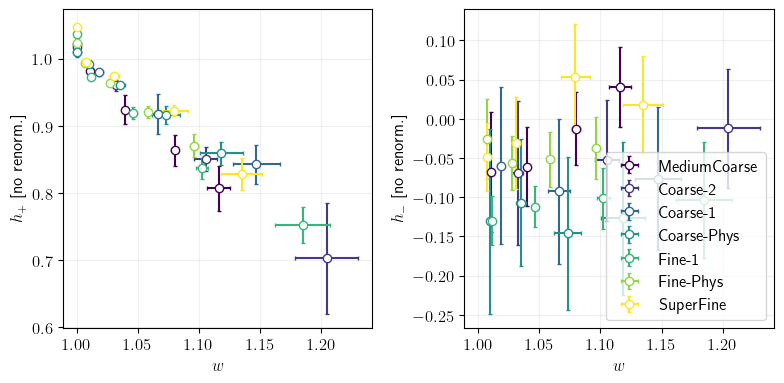

In [38]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

f, ax = plt.subplots(1,2,figsize=(8,4),sharex=True)

color = plt.cm.viridis(np.linspace(0,1,len(ENSEMBLE_LIST)))

for i,ens in enumerate(ENSEMBLE_LIST):
    ax[0].errorbar(
        gv.mean(ff['w' ][ens]),
        gv.mean(ff['h+'][ens]),
        xerr = gv.sdev(ff['w' ][ens]),
        yerr = gv.sdev(ff['h+'][ens]),
        fmt     = 'o',
        ecolor  = color[i],
        mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

    ax[1].errorbar(
        gv.mean(ff['w' ][ens][1:]),
        gv.mean(ff['h-'][ens]),
        xerr = gv.sdev(ff['w' ][ens][1:]),
        yerr = gv.sdev(ff['h-'][ens]),
        fmt     = 'o',
        ecolor  = color[i],
        mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

ax[0].set_ylabel(r'$h_+$ [no renorm.]')
ax[0].set_xlabel(r'$w$')
ax[0].grid(alpha=0.2)

ax[1].legend()
ax[1].set_ylabel(r'$h_-$ [no renorm.]')
ax[1].set_xlabel(r'$w$')
ax[1].grid(alpha=0.2)

plt.tight_layout()